# Solar Charge Predictor #
## Contents
1. Introduction
2. Data Preparation
    1. Data Collection
    1. Importing Data
    1. One Hot Encoding
3. Exploratory Analysis
    1. Correlations Heatmap
    1. Relationships of Factors
    1. Spread of Categorical Variables
4. Regression Modelling
    1. Selection
    1. Selected Model
    1. User Interface
6. Conclusion

## 1. Introduction
Given the economy 7 electricity tariff, using electricity from the grid at night is cheaper than during the day. It is cost-effective to charge the house battery at night, and discharge it during the day when electricity is expensive to import. However, given a battery and solar panels, if batteries are charged excessively, then the excess generated by the solar panels (during daytime) will be exported for less than it costs to import from the grid (at the nighttime rate).

Therefore, factors are selected to predict what percentage charge of battery should be required on a given day. Weather factors are provided by www.visualcrossing.com for the author's location.

Of the raw data, I will begin with the following factors:

Table 1: Factor Description

| Factor        |      Description             | Values   | 
|:--------------|:-----------------------------|:------:|
|Day            | Day of the week (precategorised)| Weekday, Saturday, Sunday, Monday | 
|prec_cover     | The percent of precipitation cover | % |
|cloud_cover    | The percent of cloud cover   | % |
|solar_energy   | Units of solar energy        | float |
|sunset         | Time at which the sun sets as a fraction of 24 hours | float (0-1) |
|charge_to      | The ideal % to charge the battery to    | % |

## 2. Data Preparation ##

### 2. A. Data Collection ###
Data regarding the photovoltaic system was extracted from the APK of the inverter manufacturer. Given that the battery was charged to some % at night, the optimal charge_to % would have to be calculated from the grid export (KWh) or % free battery space. Therefore, this was calculated in excel via a formula following this logic:

```
if peak_percent >= 98: #when exporting
    if charged_percent - (100*(export/10.12)) < 0: #if the export is more than battery capacity make it 0%
        charge_to = 0
    else: #otherwise you should have left how much was exported as free space
        charge_to = charged_percent - (100*(export/10.12))
else: # no export
    if peak_percent < 23: #if peak lower than 23% charge fully
        charge_to = 100
    elif 100-peak_percent+charged_percent > 100: # if peak + charged at night did not reach capacity, charge fully
        charge_to = 100
    else: # otherwise the sum between the peak and charge, compared to capacity is what you should've charged
        charge_to = 100-peak_percent+charged_percent
```

The data collection spreadsheet can be viewed in an attached file.

In [1]:
def what_charge(peak_percent, charged_percent, export):
    if peak_percent >= 98: #when exporting
        if charged_percent - (100*(export/10.12)) < 0: #if the export is more than battery capacity make it 0%
            charge_to = 0
        else: #otherwise you should have left how much was exported as free space
            charge_to = charged_percent - (100*(export/10.12))
    else: # no export
        if peak_percent < 23: #if peak lower than 23% charge fully
            charge_to = 100
        elif 100-peak_percent+charged_percent > 100: # if peak + charged at night did not reach capacity, charge fully
            charge_to = 100
        else: # otherwise the sum between the peak and charge, compared to capacity is what you should've charged
            charge_to = 100-peak_percent+charged_percent
    return charge_to

what_charge(49,22,0)

73

### 2. B. Importing Data
Table 2 shows the start and end of the solar. This 'raw' data was inputted by the author and has been checked for errors.

In [2]:
import pandas as pd

df = pd.read_csv("feb_data.csv")
print("Table 2: Raw Data")
df

Table 2: Raw Data


,day,prec_cover,cloud_cover,solar_energy,sunset,charge_to
0,Weekday,8.33,59.4,8.1,0.762188,98.000000
1,Saturday,29.17,59.5,9.3,0.757465,92.617188
2,Sunday,8.33,30.6,11.1,0.755903,76.000000
3,Monday,8.33,32.6,10.1,0.754363,84.687500
4,Weekday,0.00,6.7,10.5,0.752824,52.273438
...,...,...,...,...,...,...
279,Monday,50.00,77.0,11.9,0.883669,49.000000
280,Weekday,33.33,59.9,13.3,0.882650,0.000000
281,Weekday,8.33,42.5,17.5,0.881609,0.000000
282,Weekday,8.33,70.9,10.0,0.880532,18.093750


### 2. C. One Hot Encoding ###
The days of the week are categorical variables and need to be one-hot encoded for regression. The base category is 'Monday'

In [3]:
days = pd.get_dummies(df.day, drop_first=True) #one hot encoding
print("Table 3: One Hot Encoded Days")
days

Table 3: One Hot Encoded Days


,Saturday,Sunday,Weekday
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,0
4,0,0,1
...,...,...,...
279,0,0,0
280,0,0,1
281,0,0,1
282,0,0,1


In [4]:
combined = days.join(df)
combined = combined.drop(columns=['day'])
print("Table 4: Data Ready for Analysis")
combined

Table 4: Data Ready for Analysis


,Saturday,Sunday,Weekday,prec_cover,cloud_cover,solar_energy,sunset,charge_to
0,0,0,1,8.33,59.4,8.1,0.762188,98.000000
1,1,0,0,29.17,59.5,9.3,0.757465,92.617188
2,0,1,0,8.33,30.6,11.1,0.755903,76.000000
3,0,0,0,8.33,32.6,10.1,0.754363,84.687500
4,0,0,1,0.00,6.7,10.5,0.752824,52.273438
...,...,...,...,...,...,...,...,...
279,0,0,0,50.00,77.0,11.9,0.883669,49.000000
280,0,0,1,33.33,59.9,13.3,0.882650,0.000000
281,0,0,1,8.33,42.5,17.5,0.881609,0.000000
282,0,0,1,8.33,70.9,10.0,0.880532,18.093750


## 3. Exploratory Analysis
### 3. A. Correlations Heatmap
Figure 1 shows the correlation of the different numerical variables, the darker the colour, the more correlated the variable pair. The most significant is solar energy with charge_to. The negative value close to -1 suggests that the higher the solar energy, the lower you should charge the battery. Sunset time is highly correlated with solar energy, hence, using both should be avoided to reduce risk of errors and model overcomplexity.

Other variable correlations are close to 0 which implies there is not much relationship between them.

Figure 1: Correlation Heatmap between Variables


C:\Users\Peter\AppData\Local\Temp\ipykernel_19616\1340555033.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True),


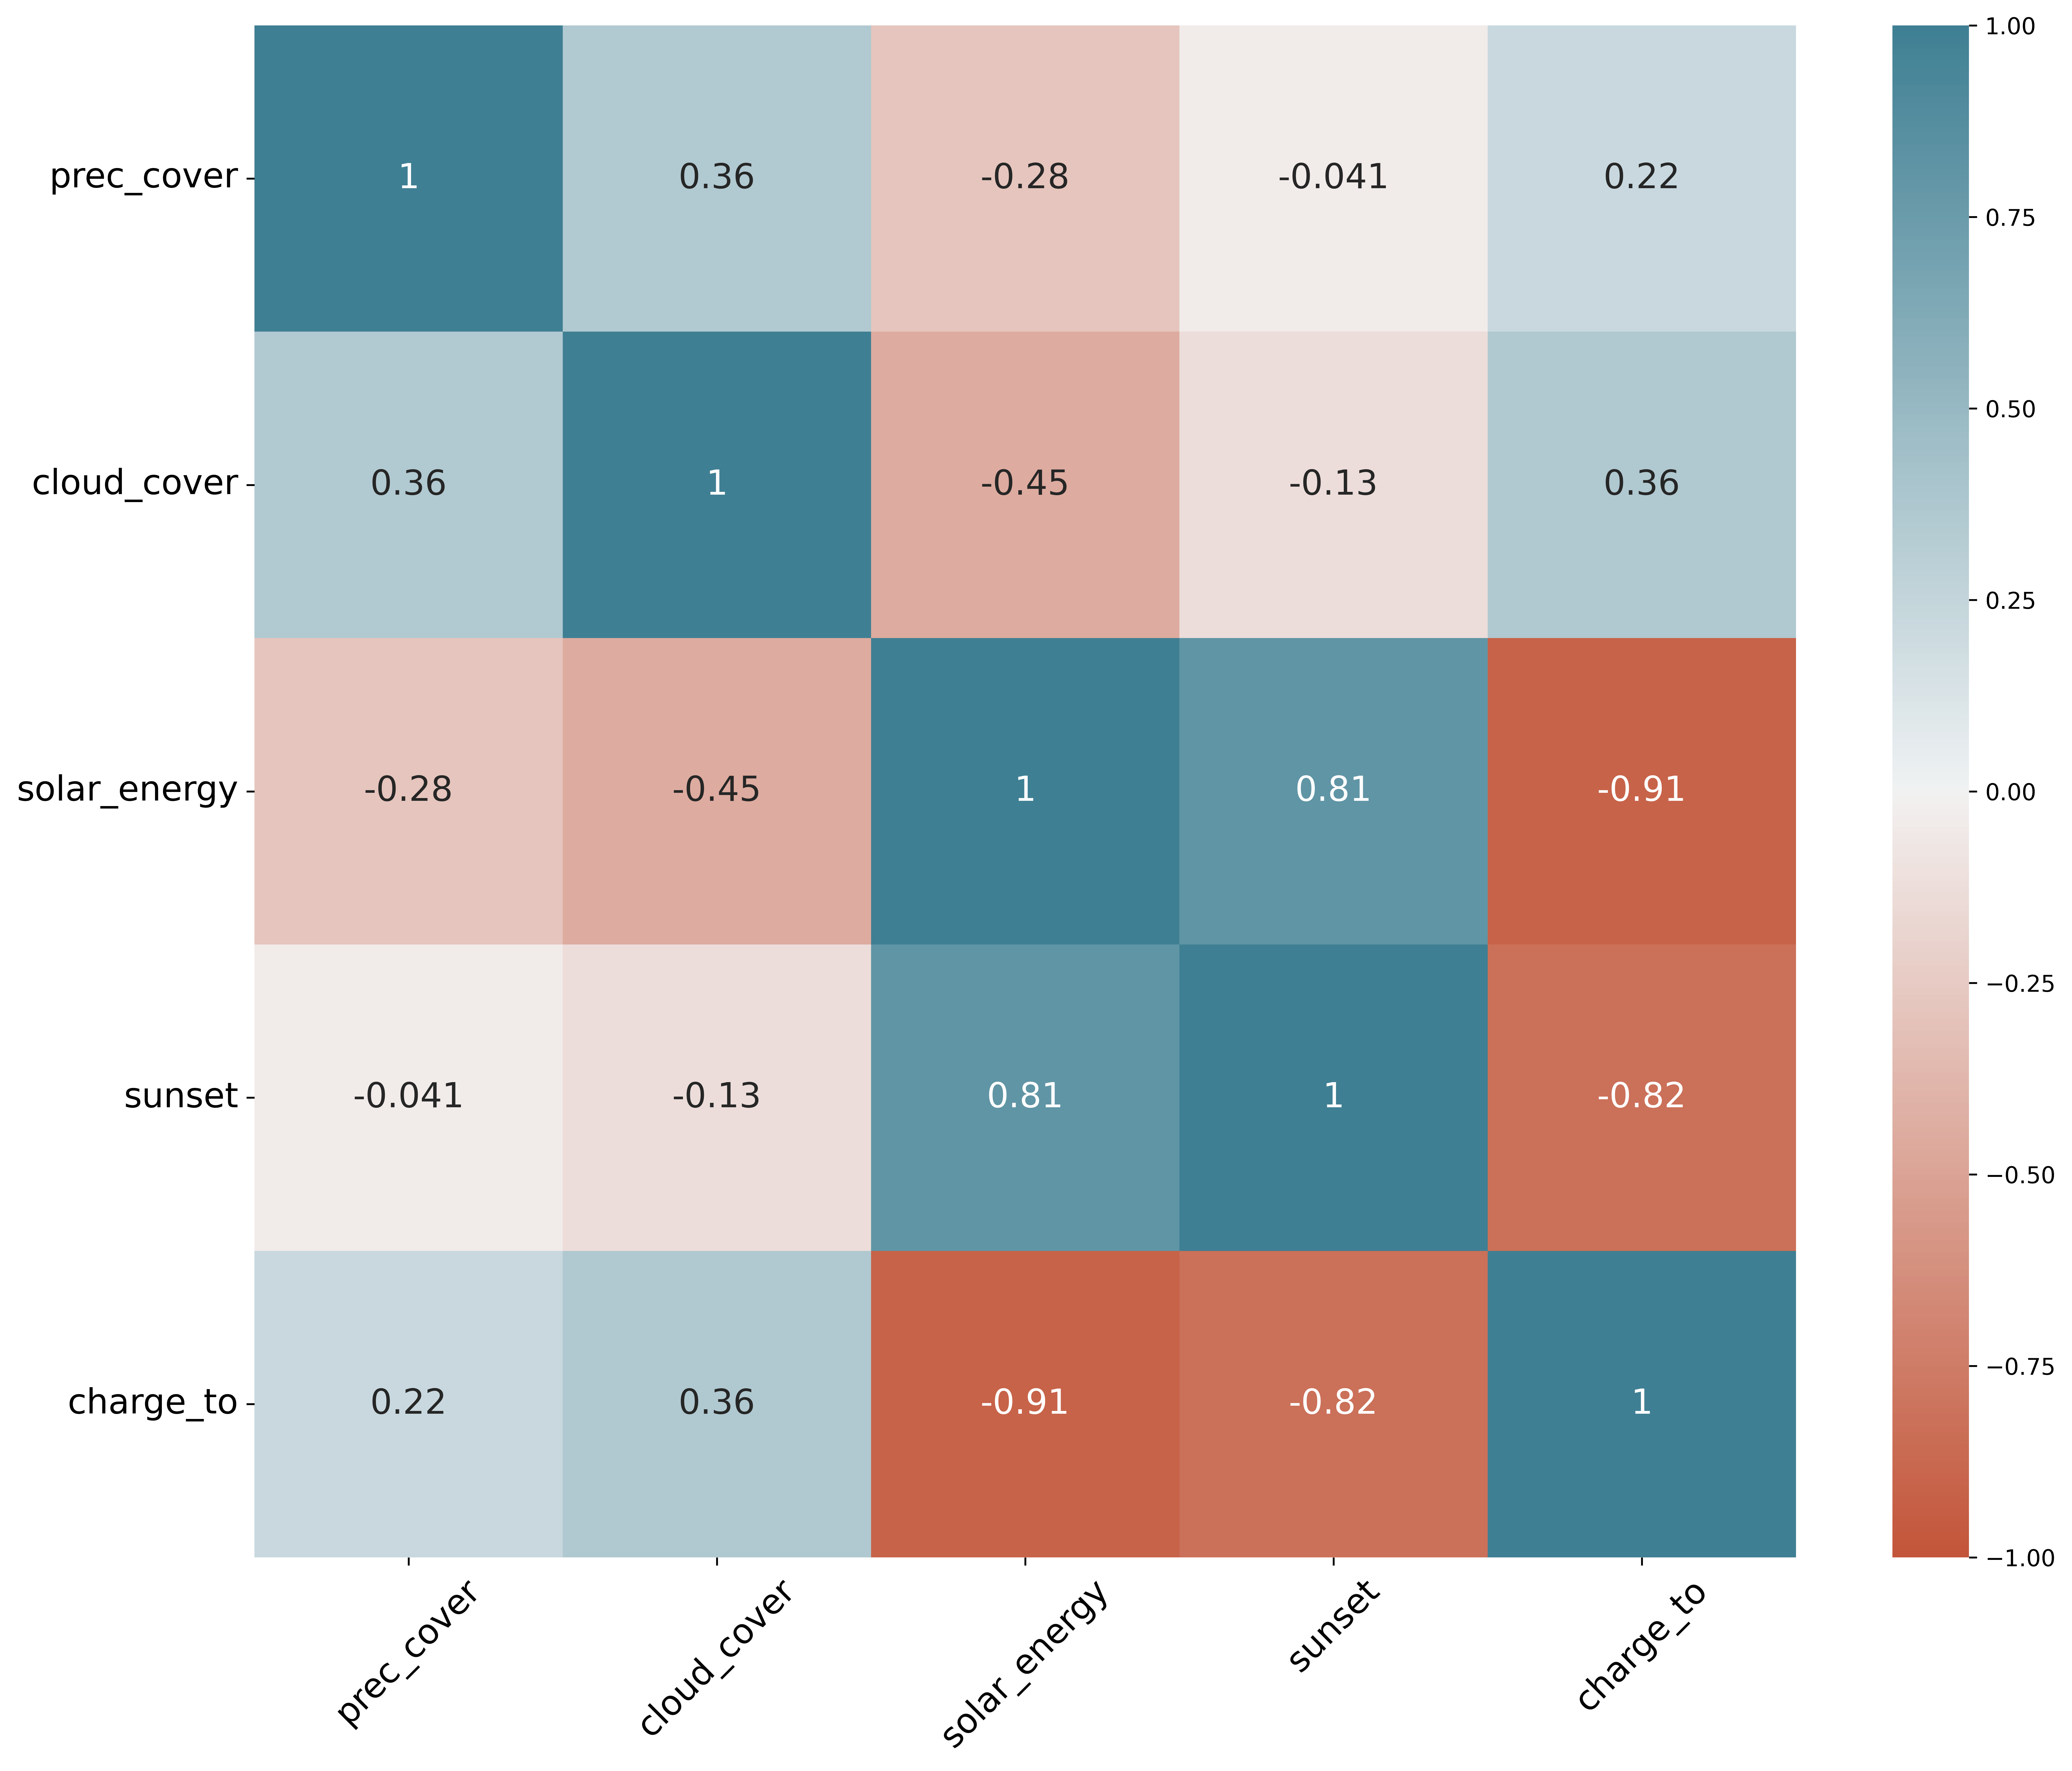

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Figure 1: Correlation Heatmap between Variables")
fig,ax = plt.subplots(1,1, figsize=(15,12), dpi=600,)
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 15})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

### 3. B. Relationships of Factors
Figure 2 shows that there is a clear negative relationship between solar energy and the % to charge the battery to at night. Figure 3 also shows a slight negative relationship between sunset time and percentage charge, however, it is more irregular which is less suitable for regression.
It is to be expected that higher cloud and precipitation cover would require a higher percentage charge, however, there is not a visible trend in Figure 4 to show this.
Based on this analysis, solar energy is the most appropriate factor to predict percentage charge.

Figure 2: Charge up to given Solar Energy


Text(0, 0.5, 'Charge up to (%)')

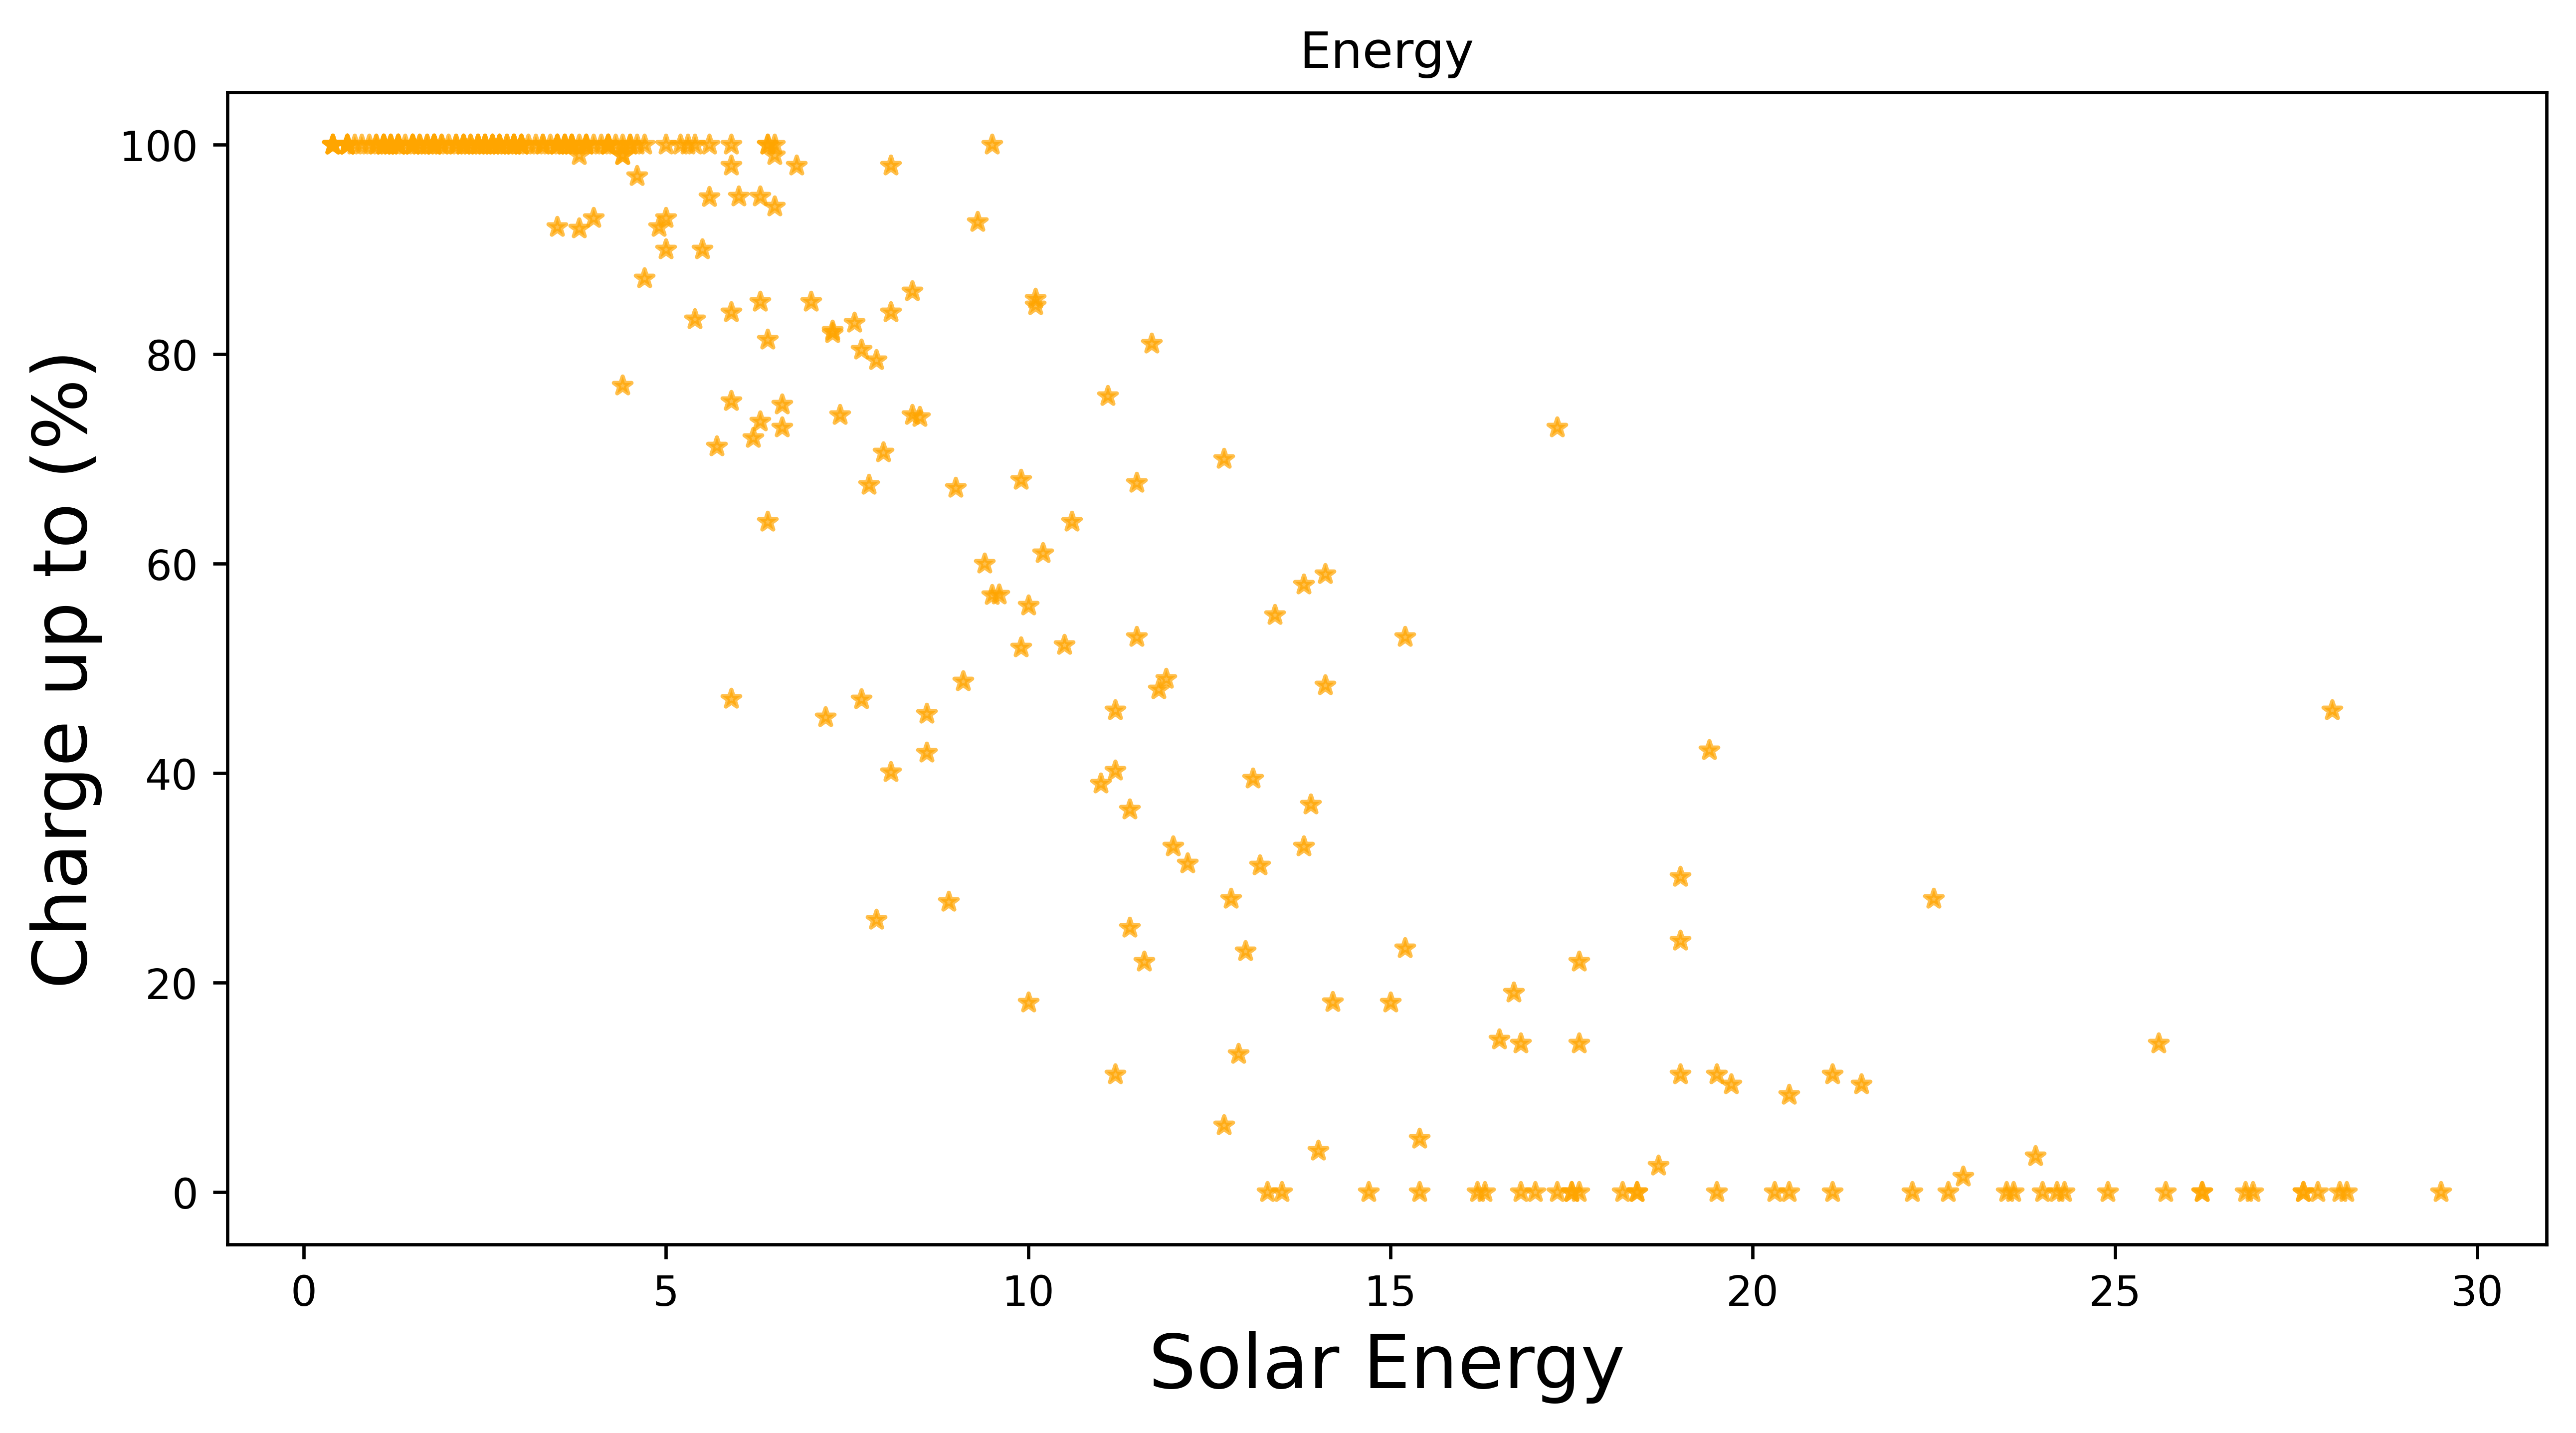

In [6]:
print("Figure 2: Charge up to given Solar Energy")
fig, (a1) = plt.subplots(1,1, dpi=600, figsize=(10,5))

combined.plot(x = "solar_energy", y = "charge_to", kind="scatter", marker='*', color='orange', alpha = 0.7, ax=a1)

a1.set_title("Energy")
a1.set_xlabel("Solar Energy", fontsize=18)
a1.set_ylabel("Charge up to (%)", fontsize=18)

Figure 3: Charge up to given Sunset time


Text(0, 0.5, 'Charge up to (%)')

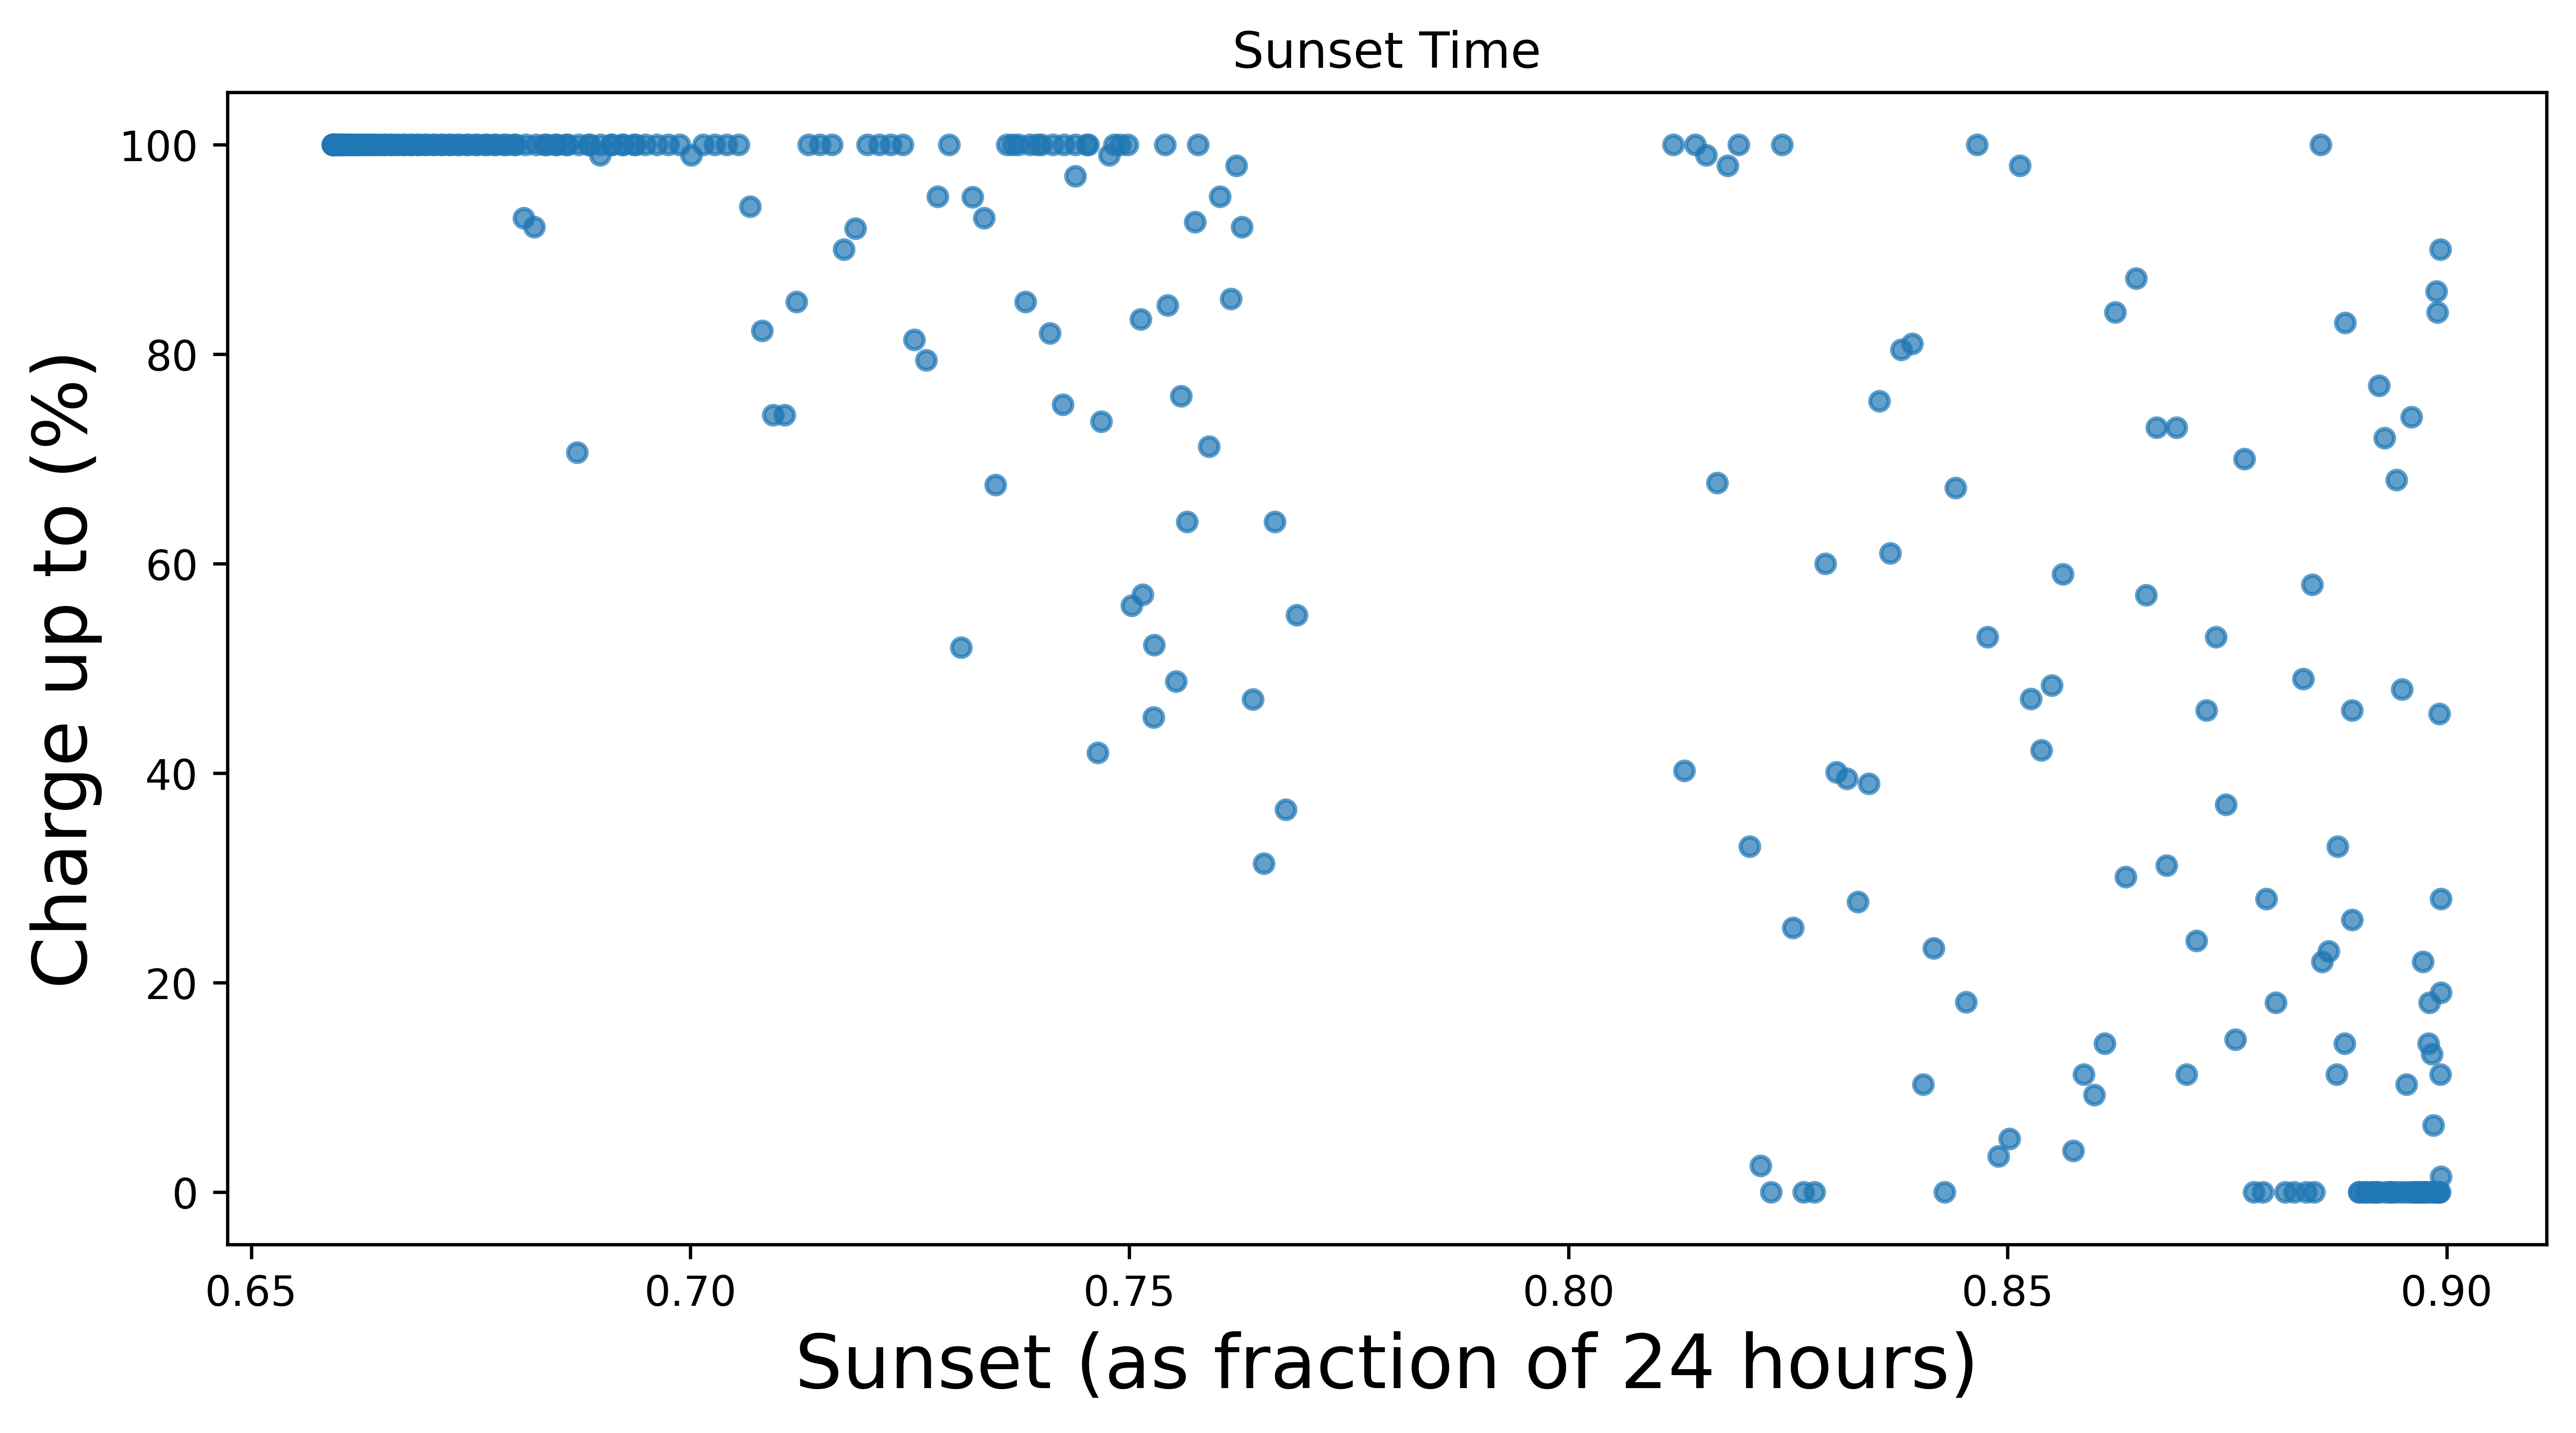

In [7]:
print("Figure 3: Charge up to given Sunset time")
fig, (a1) = plt.subplots(1,1, dpi=600, figsize=(10,5))

combined.plot(x = "sunset", y = "charge_to", kind="scatter", alpha = 0.7, ax=a1)

a1.set_title("Sunset Time")
a1.set_xlabel("Sunset (as fraction of 24 hours)", fontsize=18)
a1.set_ylabel("Charge up to (%)", fontsize=18)

Figure 4: Charge up to given Solar Energy


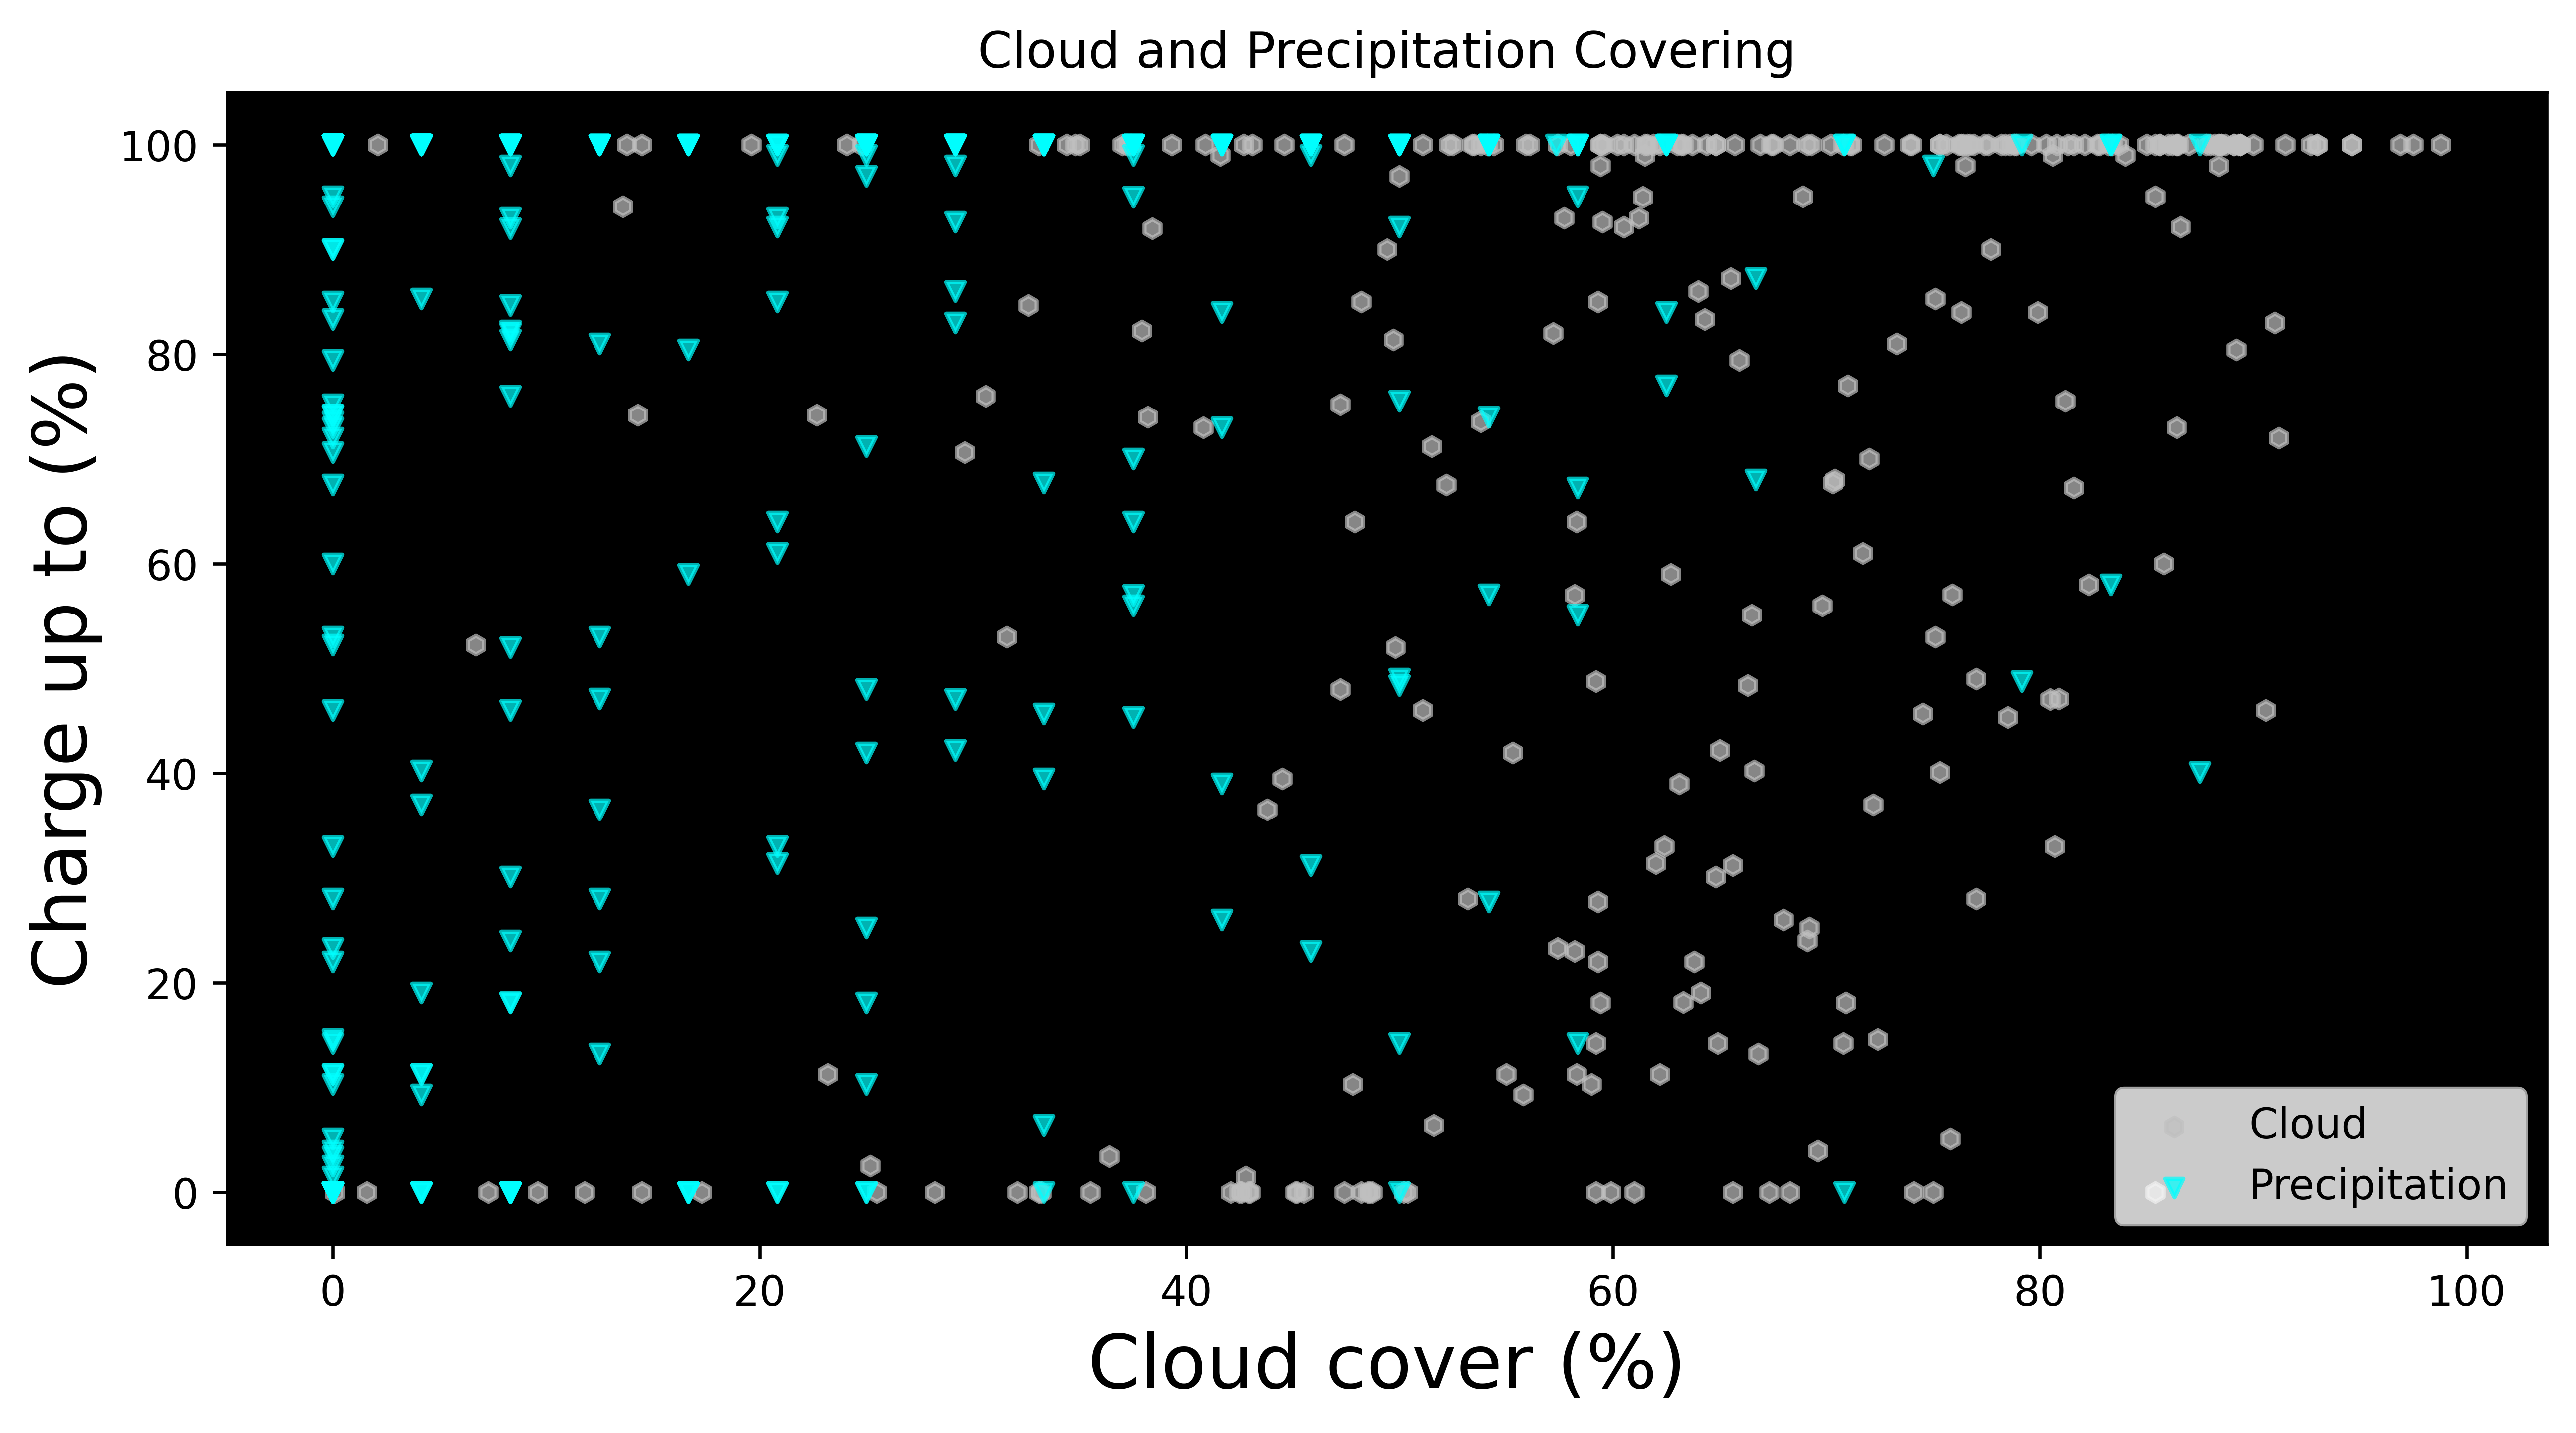

In [8]:
print("Figure 4: Charge up to given Solar Energy")
fig, (a1) = plt.subplots(1,1, dpi=600, figsize=(10,5))

combined.plot(x = "cloud_cover", y = "charge_to", kind="scatter", marker='h', color='silver', alpha = 0.7, ax=a1)
combined.plot(x = "prec_cover", y = "charge_to", kind="scatter", marker='v', color='aqua', alpha = 0.7, ax=a1)

a1.set_title("Cloud and Precipitation Covering")
a1.set_xlabel("Cloud cover (%)", fontsize=18)
a1.set_ylabel("Charge up to (%)", fontsize=18)
a1.set_facecolor('black')
a1.legend(['Cloud', 'Precipitation'])

### 3. D. Spread of Categorical Variables
Figure 4 shows little difference in spread between days of the week. This is surprising since I would expect more energy to be used when more occupants of the house were present, such as Sunday.

Figure 5: Spread of % over days


Text(0.5, 1.0, 'Spread of % on Day Type')

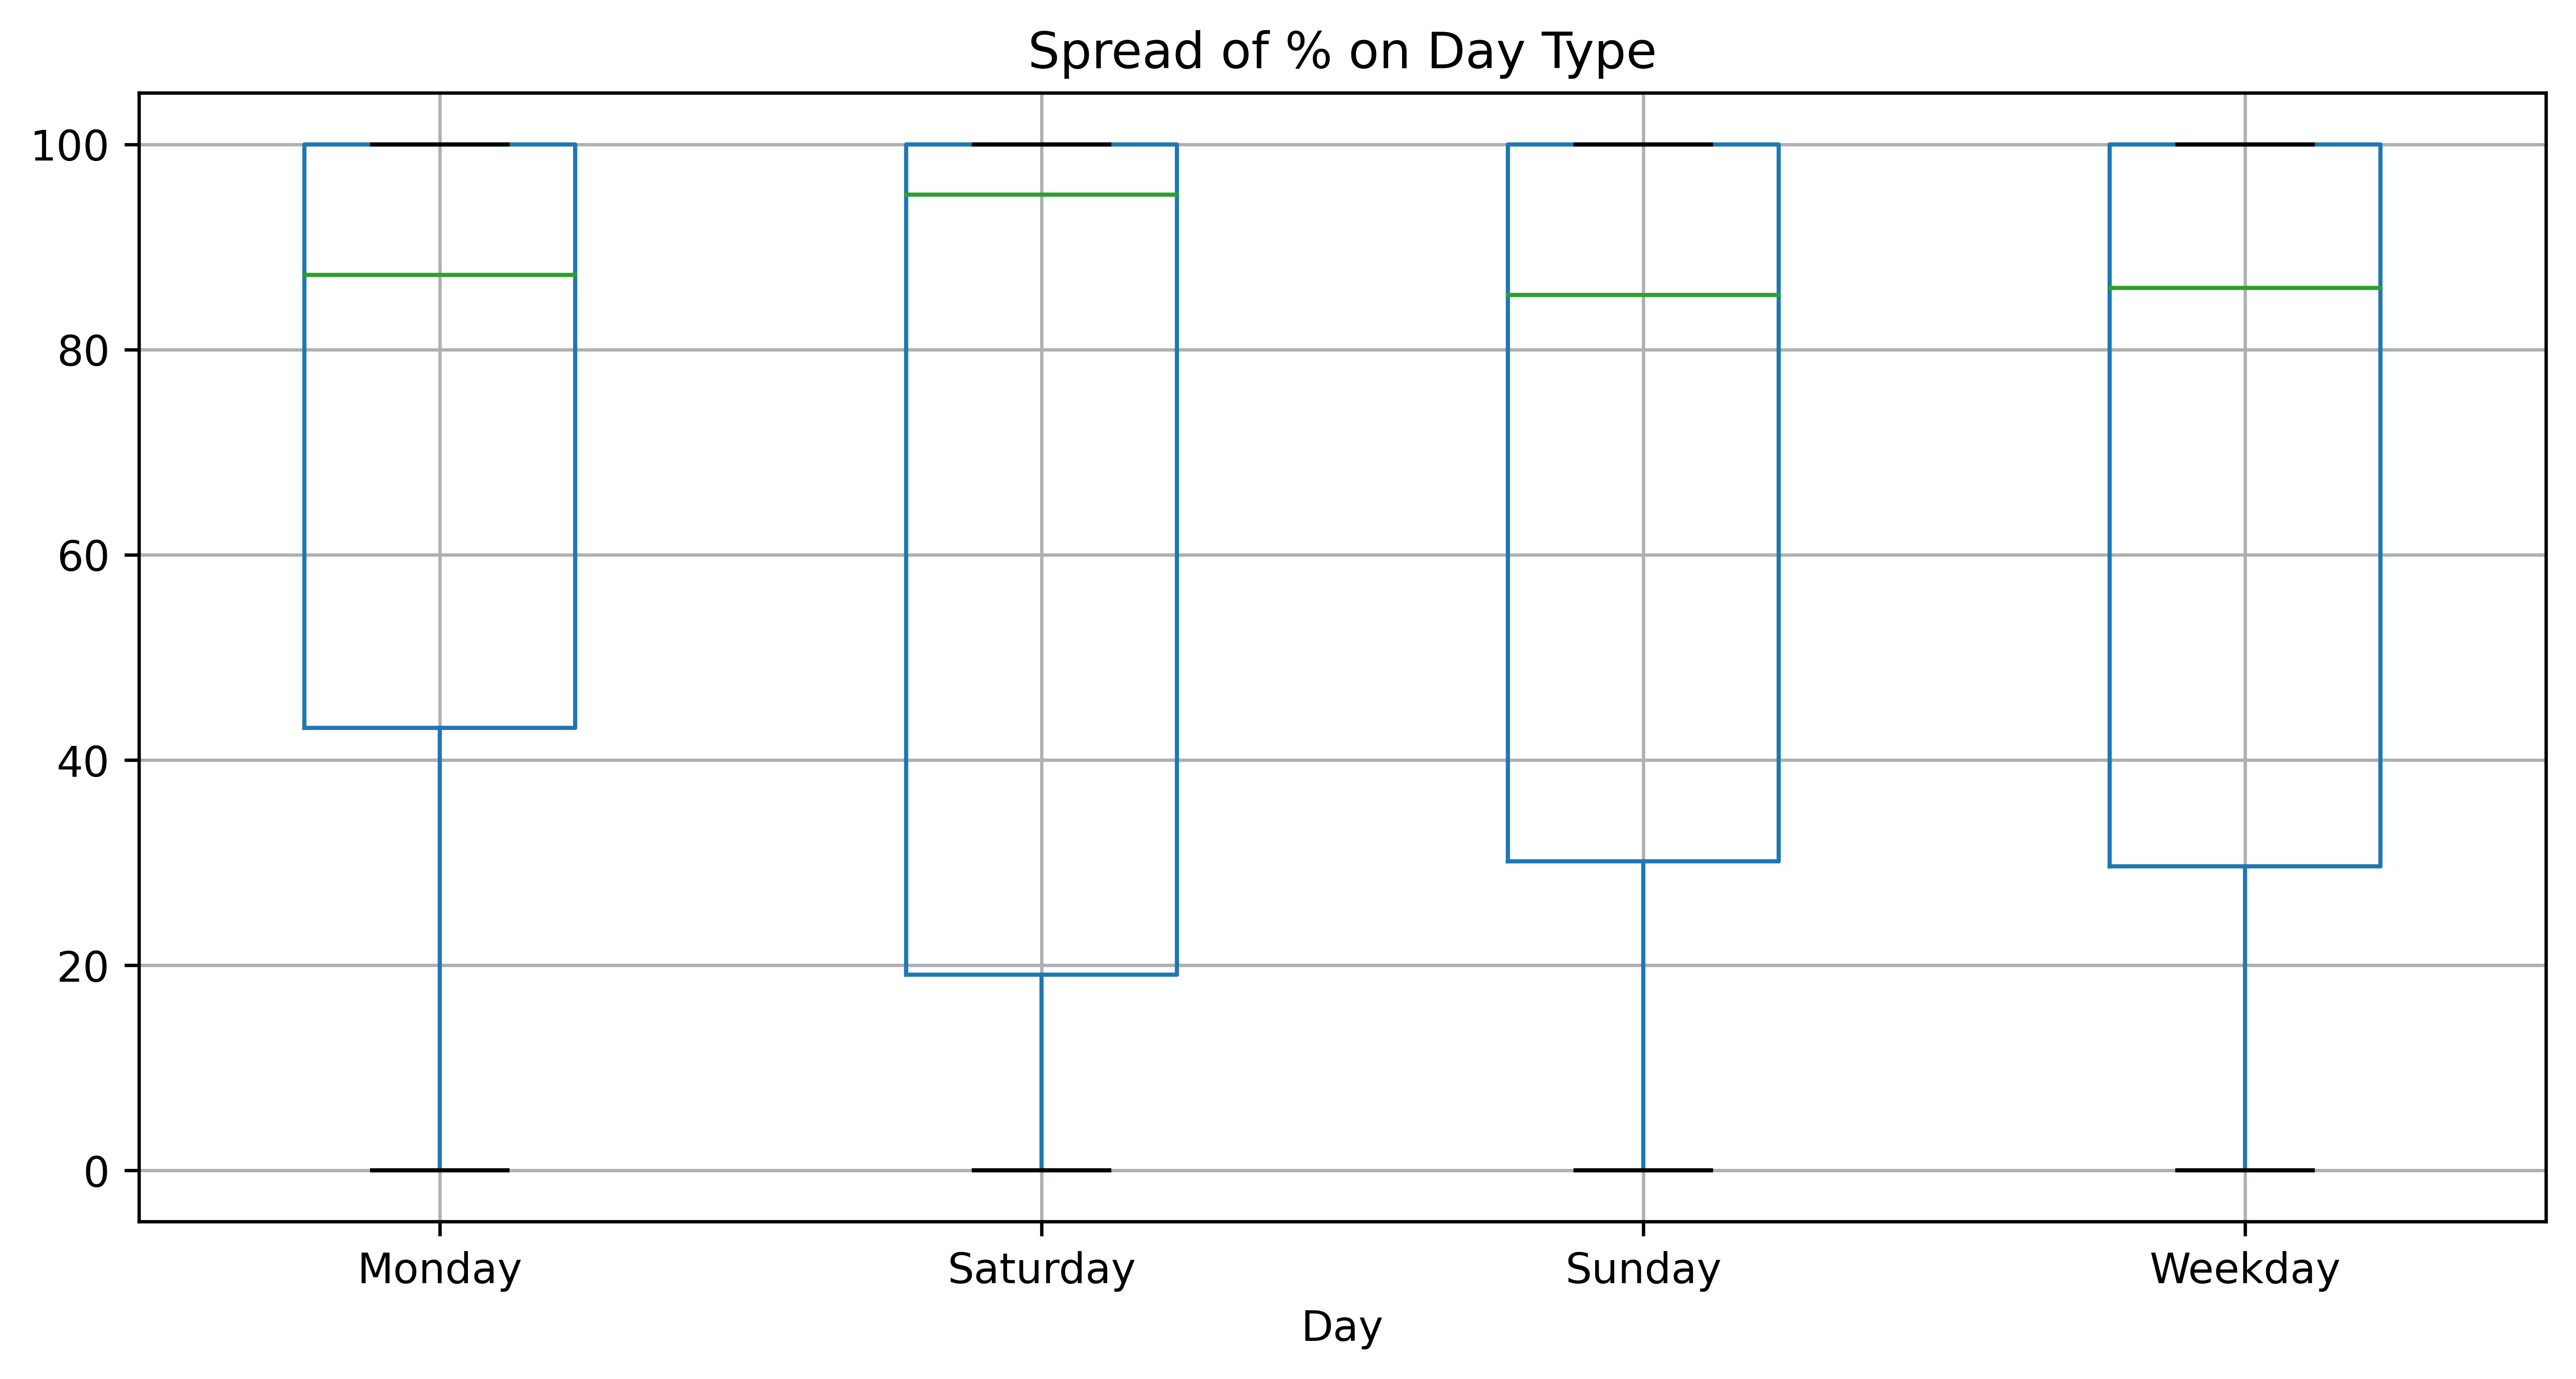

In [9]:
print("Figure 5: Spread of % over days")
fig, a1 = plt.subplots(1,1, figsize=(10,5), dpi=600)

df.boxplot(column='charge_to', by='day', ax=a1)
a1.set_xlabel('Day')
fig.suptitle('')
plt.title("Spread of % on Day Type")

## 4. Regression Modeling ##
Since one factor is to be used, this prediction can be completed via a simple regression. However, exponentials will be compared to control complexity and increase validation accuracy.
### 4. A. Selection ###
Selecting the one feature solar_energy and creating train and test set.

In [10]:
from sklearn.model_selection import train_test_split

selected = combined[["solar_energy", "charge_to"]]
selected

X = combined["solar_energy"].to_numpy()
y = combined["charge_to"].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, random_state=2)

Fitting with lines with exponential orders 1 - 9.

In [20]:
import numpy as np
print("Table 2: Train and Validation Mean Squared Error Values of different orders")


orders = range(1,9)
x_LS = np.linspace(1,30,100).T

MSE_Train = dict.fromkeys(orders)
MSE_Val = dict.fromkeys(orders)
AMSE_Train = dict.fromkeys(orders)
AMSE_Val = dict.fromkeys(orders)

for order in orders:
    p = np.poly1d(np.polyfit(X_train, y_train, int(order)))

    MSE_Train[order] = np.sum((y_train - p(X_train))**2)/10
    MSE_Val[order] = np.sum((y_val - p(X_val))**2)/20
    AMSE_Train[order] = MSE_Train[order]/len(X_train)
    AMSE_Val[order] = MSE_Val[order]/len(X_val)
    
errors = pd.DataFrame({'Order' : orders, 'MSE Train' : list(MSE_Train.values()), 'MSE Val' : list(MSE_Val.values()), 
                      'Mean MSE Train' : list(AMSE_Train.values()), 'Mean MSE Val' : list(AMSE_Val.values())})
errors

Table 2: Train and Validation Mean Squared Error Values of different orders


,Order,MSE Train,MSE Val,Mean MSE Train,Mean MSE Val
0,1,4989.833194,1193.832183,25.201178,13.881770
1,2,4334.255689,1012.422375,21.890180,11.772353
2,3,3460.353536,876.543480,17.476533,10.192366
3,4,3224.450619,798.602057,16.285104,9.286070
4,5,3221.553128,797.356868,16.270470,9.271591
5,6,3220.936035,794.477529,16.267354,9.238111
6,7,3217.209391,795.654381,16.248532,9.251795
7,8,3217.111913,795.280707,16.248040,9.247450


The order of 4 shows a low error for a reasonably low complexity.

### 4. B. Selected Model ##

The coefficients of the fitted model are:
 [-1.11183811e-03  7.72578816e-02 -1.59766251e+00  5.35803490e+00
  9.64640933e+01] 

---

The fitted model is:
            4           3         2
-0.001112 x + 0.07726 x - 1.598 x + 5.358 x + 96.46 

---

The training MSE is: 3224.451 

---

The validation MSE is:  798.602 

---



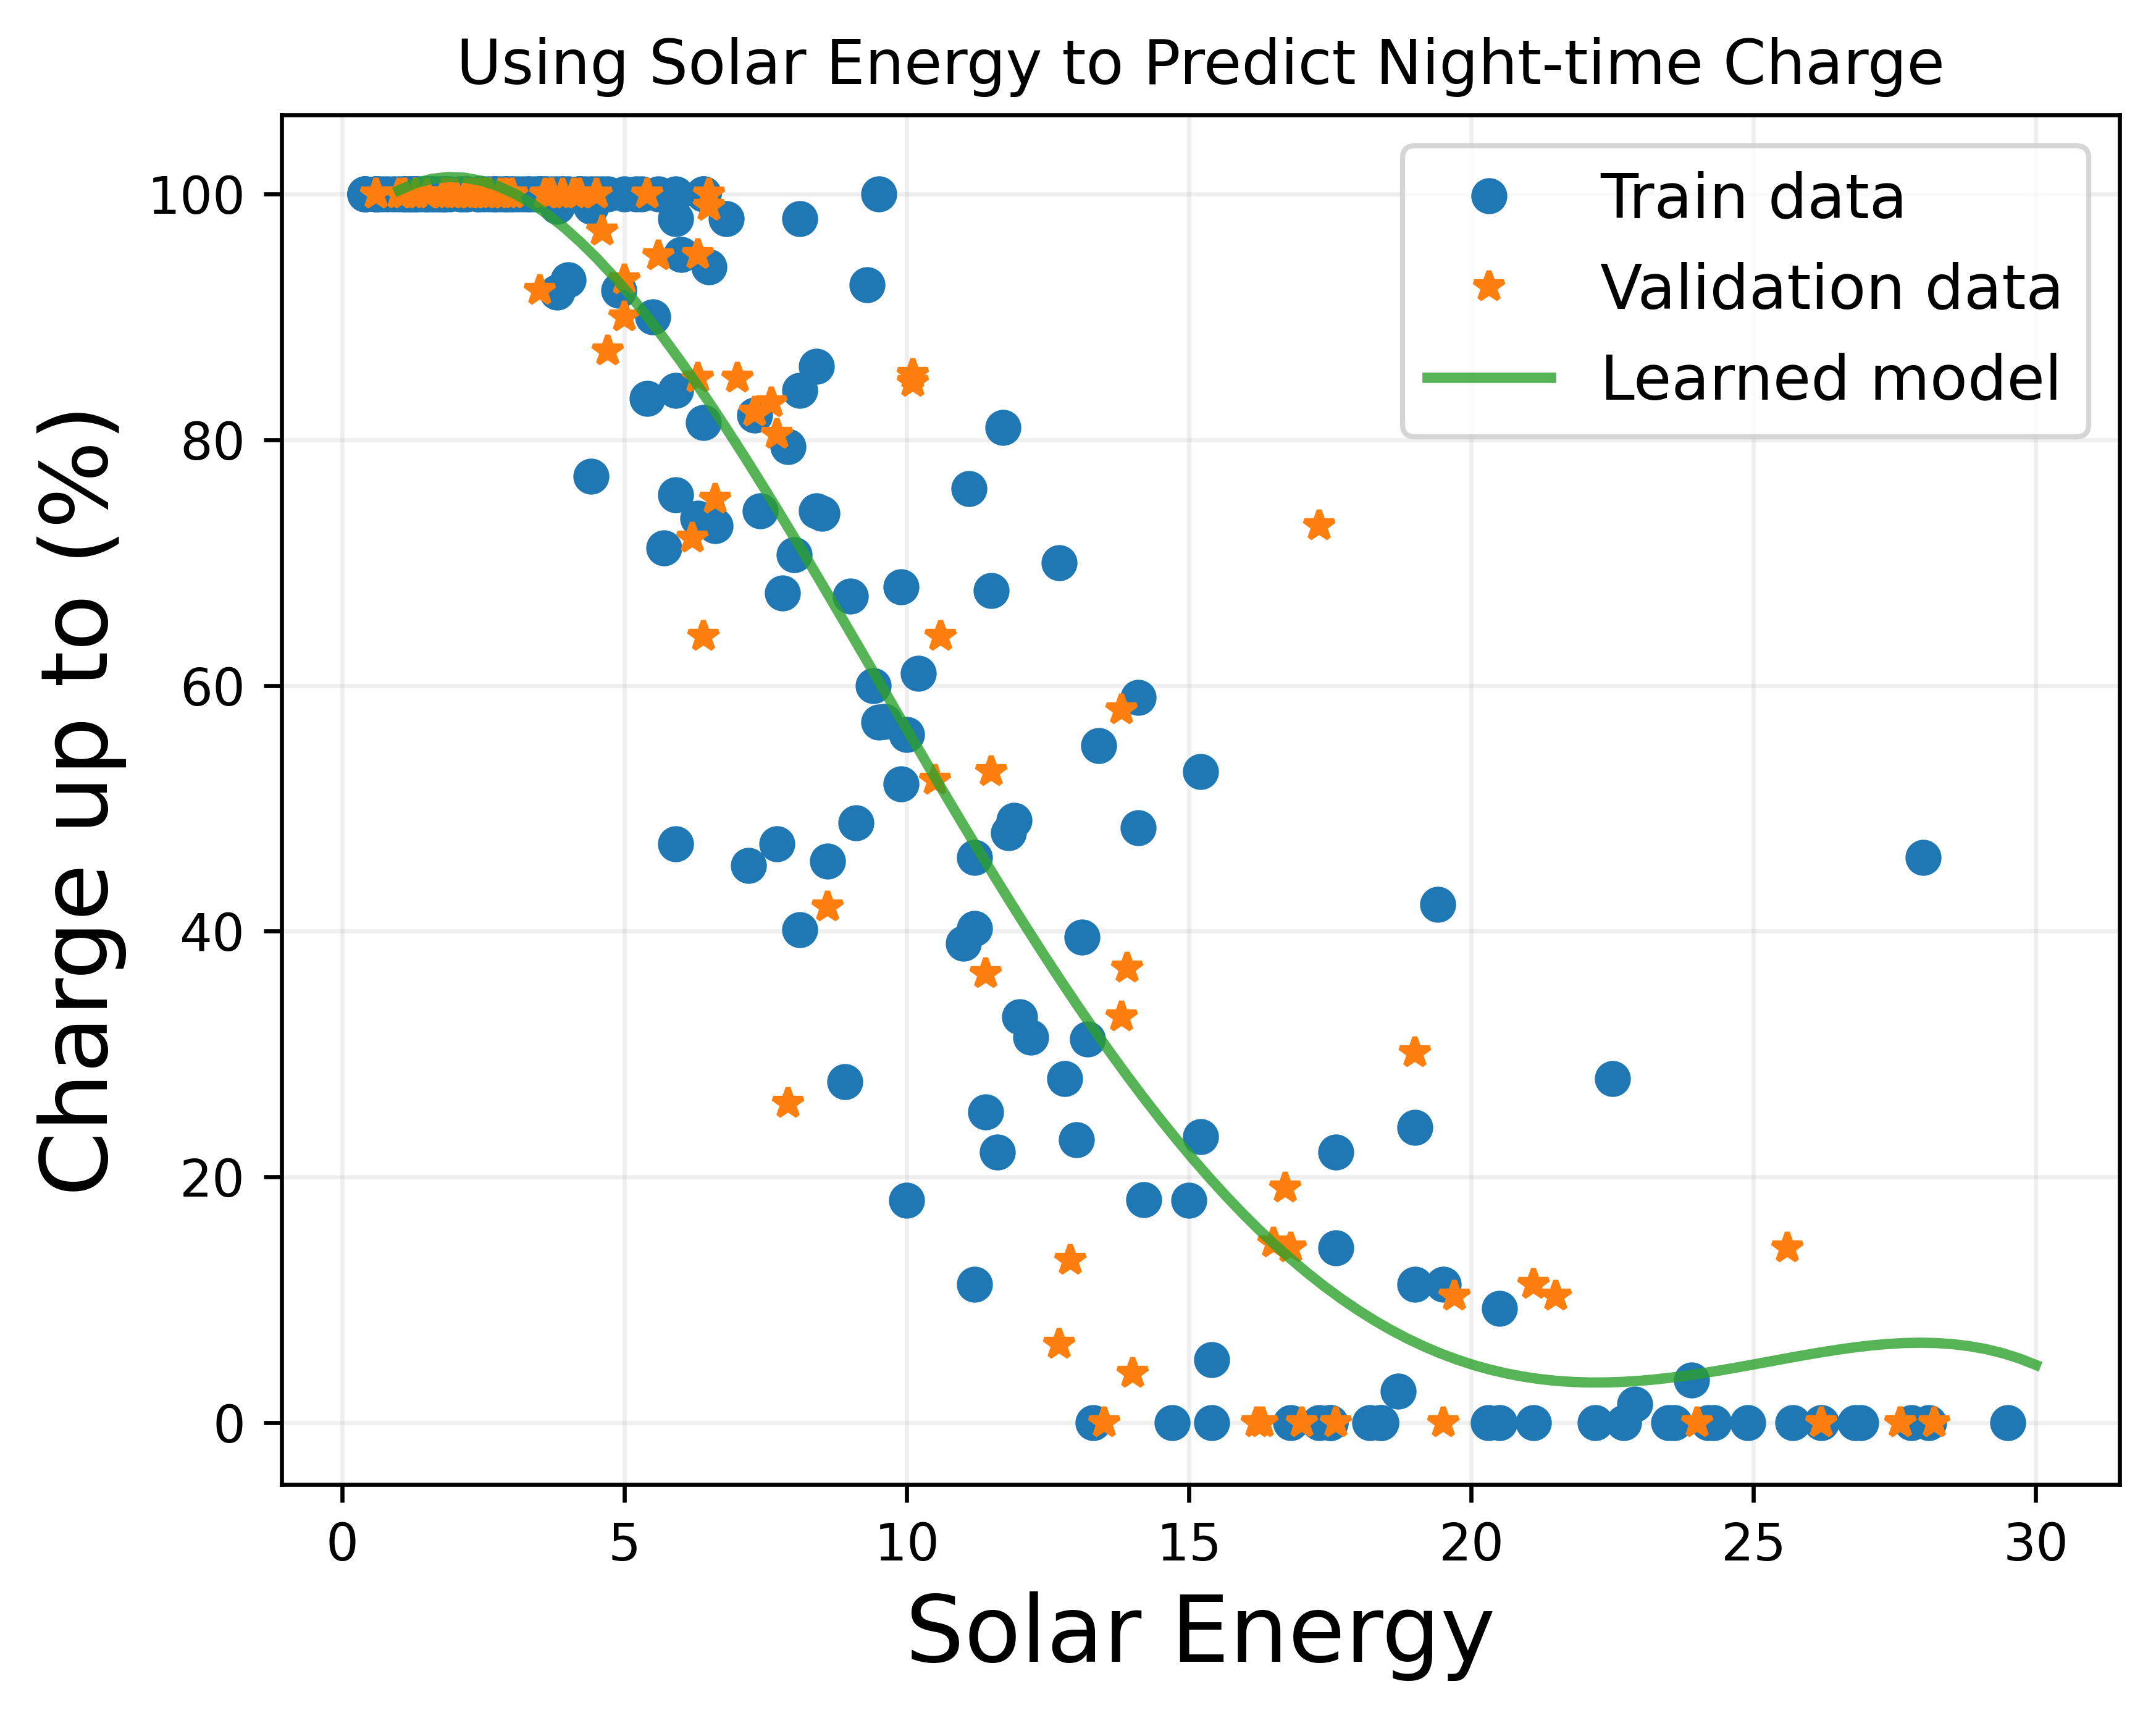

In [22]:
order = 4

p = np.poly1d(np.polyfit(X_train, y_train, int(order)))

MSE_Train[order] = np.sum((y_train - p(X_train))**2)/10
MSE_Val[order] = np.sum((y_val - p(X_val))**2)/20

fig, a1 = plt.subplots(1, 1, dpi = 600)
a1.plot(X_train, y_train, 'o', label='Train data')
a1.plot(X_val, y_val, '*', label='Validation data')
a1.plot(x_LS, p(x_LS), '-', alpha=0.8, label='Learned model', linewidth=2)

a1.set_title("Using Solar Energy to Predict Night-time Charge")
a1.set_xlabel("Solar Energy", fontsize=18)
a1.set_ylabel("Charge up to (%)", fontsize=18)
a1.grid(alpha=0.2)
a1.legend(loc='upper right', fontsize=12)

print('The coefficients of the fitted model are:\n {} \n\n---\n'.format(p.c))
print('The fitted model is:\n {} \n\n---\n'.format(p))
print('The training MSE is: {:8.3f} \n\n---\n'.format(MSE_Train[order]))
print('The validation MSE is: {:8.3f} \n\n---\n'.format(MSE_Val[order]))

## 4. C. User Interface ##
Battery percentage cannot be above 100%, nor should it discharge below 22% for longevity. Run the cell to for a prediction.

In [23]:
energy = float(input("Enter solar energy: "))

if int(p(energy)) > 100:
    bounded = 100
elif int(p(energy)) < 0:
    bounded = 0
else:
    bounded = int(p(energy))

print("Charge to " + str(bounded) + "% tonight")

Enter solar energy: 22
Charge to 3% tonight


# 5. Conclusion # 
This project set out to predict the best percentage to charge the house battery of the photo-voltaic system at night. Analysis of  weather factors show that the only feasible factor to predict this is solar energy, as other factors have little correlation with the label or are co-correlated.
The performance of regression of different exponents was compared, which resulted in the choosing of an order of 4, resulting in a regression line that follows the general trend of the relationship with low error and acceptable fitting.